In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import datetime as dt 
import seaborn as sns
import osmnx as ox
from collections import defaultdict
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import cosine_similarity
import folium

In [2]:
df_05 = pd.read_csv('/Users/mariu/Desktop/Masterarbeit/archive/202205-divvy-tripdata.csv')
df_06 = pd.read_csv('/Users/mariu/Desktop/Masterarbeit/archive/202206-divvy-tripdata.csv')
df_07 = pd.read_csv('/Users/mariu/Desktop/Masterarbeit/archive/202207-divvy-tripdata.csv')
df_08 = pd.read_csv('/Users/mariu/Desktop/Masterarbeit/archive/202208-divvy-tripdata.csv')
df_09 = pd.read_csv('/Users/mariu/Desktop/Masterarbeit/archive/202209-divvy-publictripdata.csv')
df_10 = pd.read_csv('/Users/mariu/Desktop/Masterarbeit/archive/202210-divvy-tripdata.csv')
df_11 = pd.read_csv('/Users/mariu/Desktop/Masterarbeit/archive/202211-divvy-tripdata.csv')
df_12 = pd.read_csv('/Users/mariu/Desktop/Masterarbeit/archive/202212-divvy-tripdata.csv')
df_01 = pd.read_csv('/Users/mariu/Desktop/Masterarbeit/archive/202301-divvy-tripdata.csv')
df_02 = pd.read_csv('/Users/mariu/Desktop/Masterarbeit/archive/202302-divvy-tripdata.csv')
df_03 = pd.read_csv('/Users/mariu/Desktop/Masterarbeit/archive/202303-divvy-tripdata.csv')
df_04 = pd.read_csv('/Users/mariu/Desktop/Masterarbeit/archive/202304-divvy-tripdata.csv')

df = pd.concat([df_05, df_06, df_07, df_08, df_09, df_10, df_11, df_12, df_01, df_02, df_03, df_04], ignore_index=True)
df = df.dropna().reset_index()

unique_stations_start = df.groupby('end_station_id').first().reset_index()

df['started_at'] = pd.to_datetime(df['started_at'])
df['ended_at'] = pd.to_datetime(df['ended_at'])


df['ride_duration'] = (df['ended_at'] - df['started_at']).dt.total_seconds() / 60


df = df[(df['ride_duration'] >= 5) & (df['ride_duration'] <= 120)]

df_start = df

In [3]:

# Angenommen, df ist dein Haupt-DataFrame, der alle Trips enthält

# Berechnung der Gesamttrips je Station
total_trips_per_station = df_start.groupby('end_station_id')['ride_id'].count().reset_index(name='total_trips')

# Filtern der Stationen mit weniger als 100 Trips
stations_to_remove = total_trips_per_station[total_trips_per_station['total_trips'] < 200]['end_station_id']

# Entfernen der Stationen mit weniger als 100 Trips aus dem Haupt-DataFrame
df_filtered = df_start[~df_start['end_station_id'].isin(stations_to_remove)]

unique_stations_filtered = unique_stations_start[~unique_stations_start['end_station_id'].isin(stations_to_remove)]

/Users/mariu/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/mariu/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/mariu/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/mariu/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/mariu/anacond

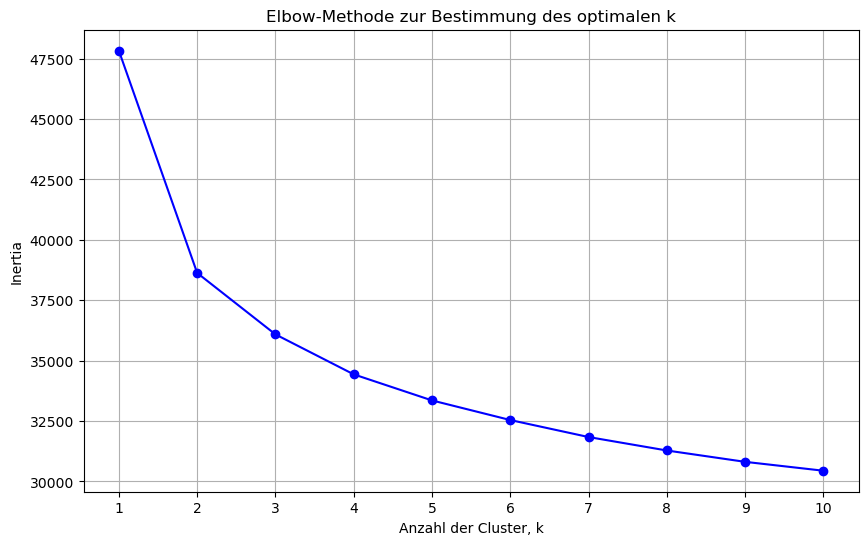

In [4]:
# Sicherstellen, dass df eine eigenständige Kopie ist, nicht eine Ansicht
df = df_filtered.copy()

# Konvertierung von 'started_at' zu datetime (falls noch nicht geschehen)
df['ended_at'] = pd.to_datetime(df['ended_at'])

# Extraktion von Stunde und Wochentag mit .loc, um Warnungen zu vermeiden
df.loc[:, 'hour'] = df['ended_at'].dt.hour
df.loc[:, 'weekday'] = df['ended_at'].dt.dayofweek

# Erstellen einer 'weekday_hour' Spalte, die 'weekday' und 'hour' kombiniert
df.loc[:, 'weekday_hour'] = df['weekday'].astype(str) + "_" + df['hour'].astype(str).str.zfill(2)  # zfill sorgt für die korrekte Sortierung

# Erstellen des Pivot-Tables
pivot_df = df.pivot_table(index='end_station_id', 
                          columns='weekday_hour', 
                          values='ride_id', 
                          aggfunc='count', 
                          fill_value=0).reset_index()

# Um die Spalten in chronologischer Reihenfolge zu sortieren
sorted_columns = ['end_station_id'] + sorted([col for col in pivot_df.columns if col != 'end_station_id'])
pivot_df = pivot_df[sorted_columns]

features = pivot_df.drop('end_station_id', axis=1)
# Initiate the scaler
scaler = StandardScaler()

# Apply the scaler row-wise and reformat the result for kmeans
scaled_features_rowwise = np.vstack(features.apply(lambda row: scaler.fit_transform(row.values.reshape(-1, 1)).flatten(), axis=1))

# Elbow method
inertia = []
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features_rowwise)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, 'bo-')
plt.xlabel('Anzahl der Cluster, k')
plt.ylabel('Inertia')
plt.title('Elbow-Methode zur Bestimmung des optimalen k')
plt.xticks(K_range)
plt.grid(True)
plt.show()

/Users/mariu/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/mariu/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/mariu/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/mariu/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/mariu/anacond

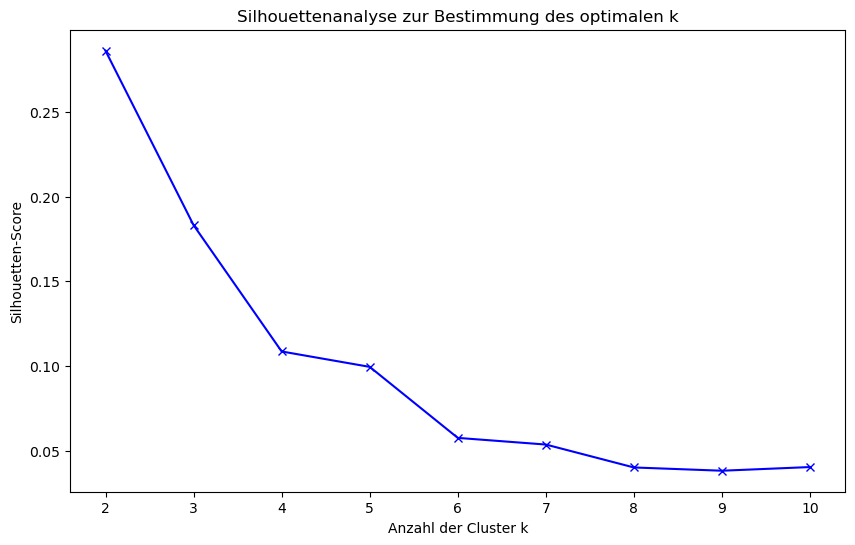

In [5]:
# Sicherstellen, dass df eine eigenständige Kopie ist, nicht eine Ansicht


df = df_filtered.copy()

# Konvertierung von 'started_at' zu datetime (falls noch nicht geschehen)
df['ended_at'] = pd.to_datetime(df['ended_at'])

# Extraktion von Stunde und Wochentag mit .loc, um Warnungen zu vermeiden
df.loc[:, 'hour'] = df['ended_at'].dt.hour
df.loc[:, 'weekday'] = df['ended_at'].dt.dayofweek

# Erstellen einer 'weekday_hour' Spalte, die 'weekday' und 'hour' kombiniert
df.loc[:, 'weekday_hour'] = df['weekday'].astype(str) + "_" + df['hour'].astype(str).str.zfill(2)  # zfill sorgt für die korrekte Sortierung

# Erstellen des Pivot-Tables
pivot_df = df.pivot_table(index='end_station_id', 
                          columns='weekday_hour', 
                          values='ride_id', 
                          aggfunc='count', 
                          fill_value=0).reset_index()

# Um die Spalten in chronologischer Reihenfolge zu sortieren
sorted_columns = ['end_station_id'] + sorted([col for col in pivot_df.columns if col != 'end_station_id'])
pivot_df = pivot_df[sorted_columns]

features = pivot_df.drop('end_station_id', axis=1)
# Initiate the scaler
scaler = StandardScaler()

# Apply the scaler row-wise and reformat the result for kmeans
scaled_features_rowwise = np.vstack(features.apply(lambda row: scaler.fit_transform(row.values.reshape(-1, 1)).flatten(), axis=1))

silhouette_scores = []
K = range(2, 11)  # Silhouetten-Score kann nicht mit k=1 berechnet werden
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features_rowwise)
    cluster_labels = kmeans.labels_
    silhouette_scores.append(silhouette_score(scaled_features_rowwise, cluster_labels))

plt.figure(figsize=(10, 6))
plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('Anzahl der Cluster k')
plt.ylabel('Silhouetten-Score')
plt.title('Silhouettenanalyse zur Bestimmung des optimalen k')
plt.show()



In [12]:
# Sicherstellen, dass df eine eigenständige Kopie ist, nicht eine Ansicht
df = df_filtered.copy()

# Konvertierung von 'started_at' zu datetime (falls noch nicht geschehen)
df['ended_at'] = pd.to_datetime(df['ended_at'])

# Extraktion von Stunde und Wochentag mit .loc, um Warnungen zu vermeiden
df.loc[:, 'hour'] = df['ended_at'].dt.hour
df.loc[:, 'weekday'] = df['ended_at'].dt.dayofweek

# Erstellen einer 'weekday_hour' Spalte, die 'weekday' und 'hour' kombiniert
df.loc[:, 'weekday_hour'] = df['weekday'].astype(str) + "_" + df['hour'].astype(str).str.zfill(2)  # zfill sorgt für die korrekte Sortierung

# Erstellen des Pivot-Tables
pivot_df = df.pivot_table(index='end_station_id', 
                          columns='weekday_hour', 
                          values='ride_id', 
                          aggfunc='count', 
                          fill_value=0).reset_index()

# Um die Spalten in chronologischer Reihenfolge zu sortieren
sorted_columns = ['end_station_id'] + sorted([col for col in pivot_df.columns if col != 'end_station_id'])
pivot_df = pivot_df[sorted_columns]

features = pivot_df.drop('end_station_id', axis=1)
# Initiate the scaler
scaler = StandardScaler()

# Apply the scaler row-wise and reformat the result for kmeans
scaled_features_rowwise = np.vstack(features.apply(lambda row: scaler.fit_transform(row.values.reshape(-1, 1)).flatten(), axis=1))

# Now, scaled_features_rowwise is correctly formatted for kmeans
kmeans = KMeans(n_clusters=3)  # Adjust the number of clusters as needed for your analysis
clusters = kmeans.fit_predict(scaled_features_rowwise)

# Add the cluster assignments back to the DataFrame
pivot_df['cluster'] = clusters

df = df_filtered.merge(pivot_df[['end_station_id', 'cluster']], on='end_station_id', how='left')
unique_stations = unique_stations_filtered.merge(pivot_df[['end_station_id', 'cluster']], on='end_station_id', how='left')

# Zählen, wie oft jedes Cluster vorkommt
cluster_counts_stations = unique_stations['cluster'].value_counts()

# Ausgabe der Anzahlen
print(cluster_counts_stations)

# Zählen, wie oft jedes Cluster vorkommt
cluster_counts_df = df['cluster'].value_counts()

# Ausgabe der Anzahlen
print(cluster_counts_df)

/Users/mariu/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


1.0    347
0.0    177
2.0     90
Name: cluster, dtype: int64
1    2198964
0     734882
2     659056
Name: cluster, dtype: int64


In [13]:

unique_stations = unique_stations.dropna(subset=['cluster'])
unique_stations['cluster'] = unique_stations['cluster'].astype(int)
# Erstellung einer Karte zentriert um die durchschnittlichen Koordinaten
map_clusters = folium.Map(location=[unique_stations['end_lat'].mean(), unique_stations['end_lng'].mean()], zoom_start=13)

# Farben für die Cluster
colors = ['blue', 'orange', 'green', 'purple', 'red', 'darkred', 'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray']

# Hinzufügen der Stationen zur Karte mit farbiger Markierung je nach Cluster
for lat, lon, cluster in zip(unique_stations['end_lat'], unique_stations['end_lng'], unique_stations['cluster']):
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        color=colors[cluster % len(colors)],  # Um sicherzustellen, dass die Farbenindexierung innerhalb der Grenzen bleibt
        fill=True,
        fill_color=colors[cluster % len(colors)],
        fill_opacity=0.7).add_to(map_clusters)

# Anzeige der Karte direkt im Notebook
map_clusters

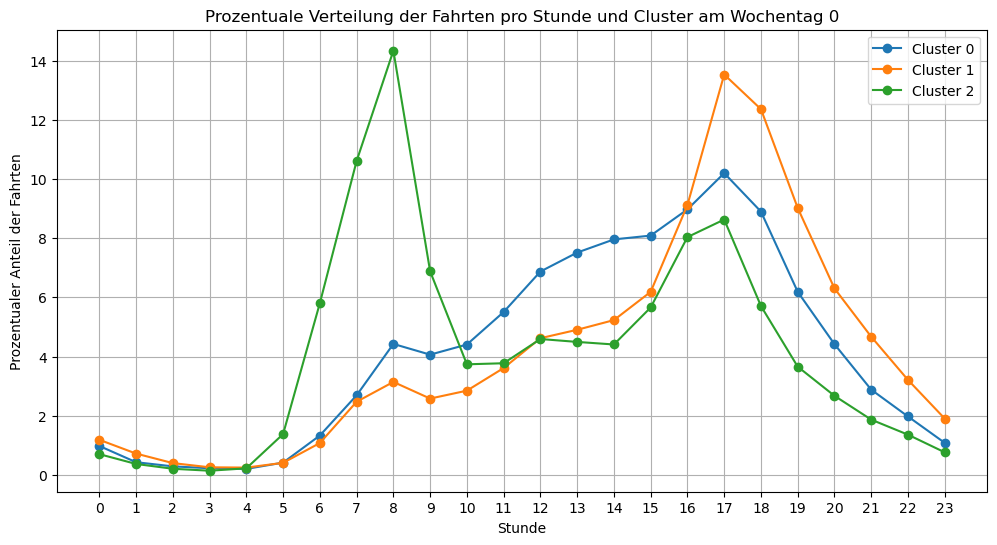

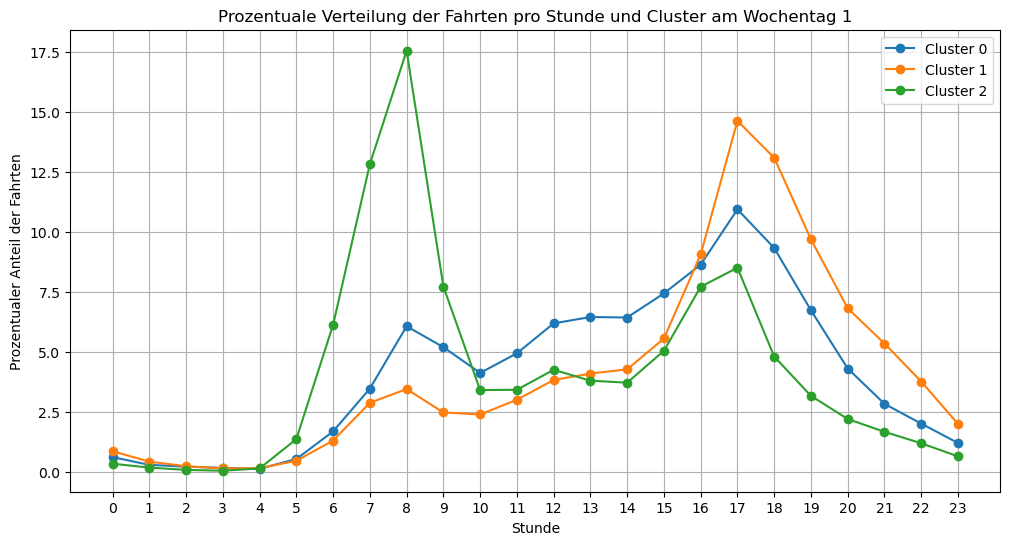

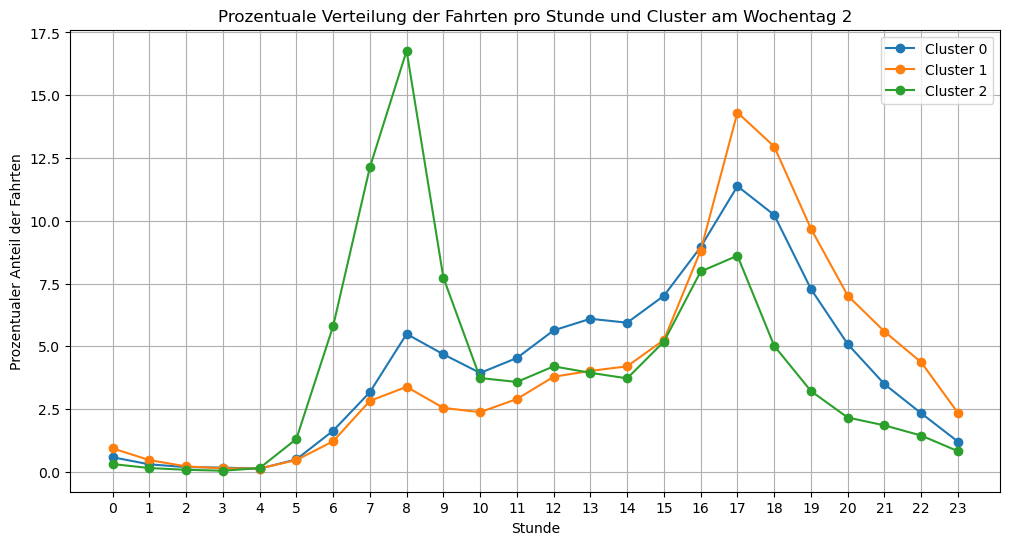

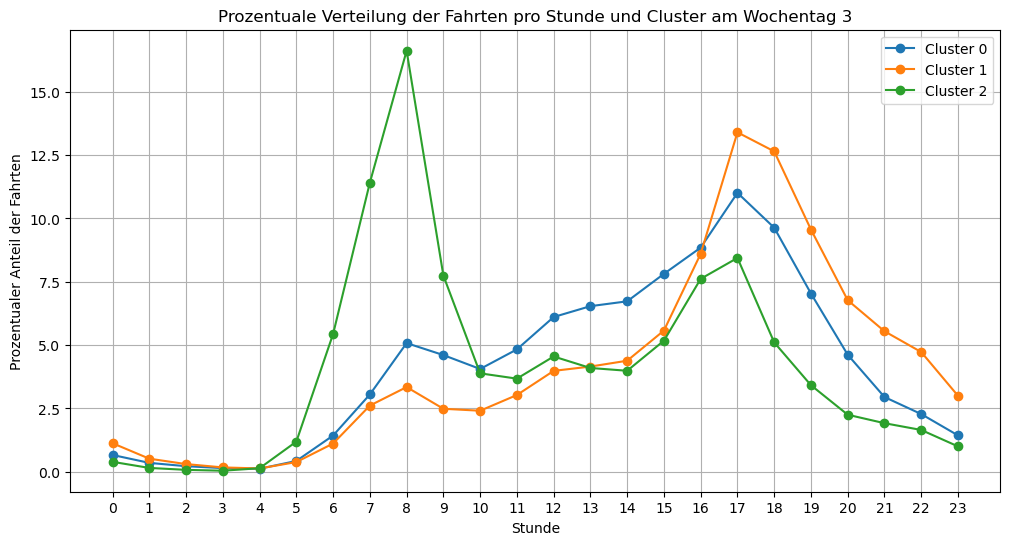

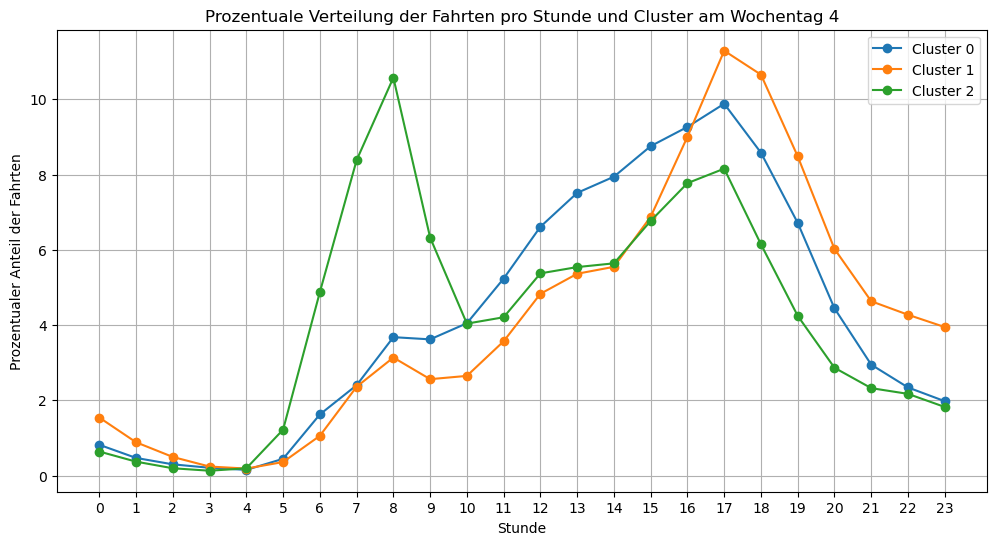

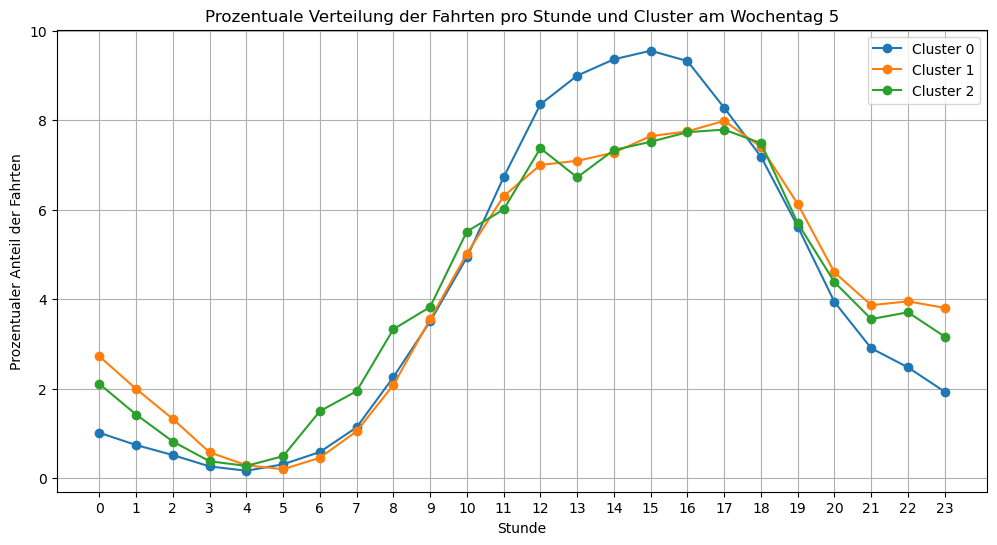

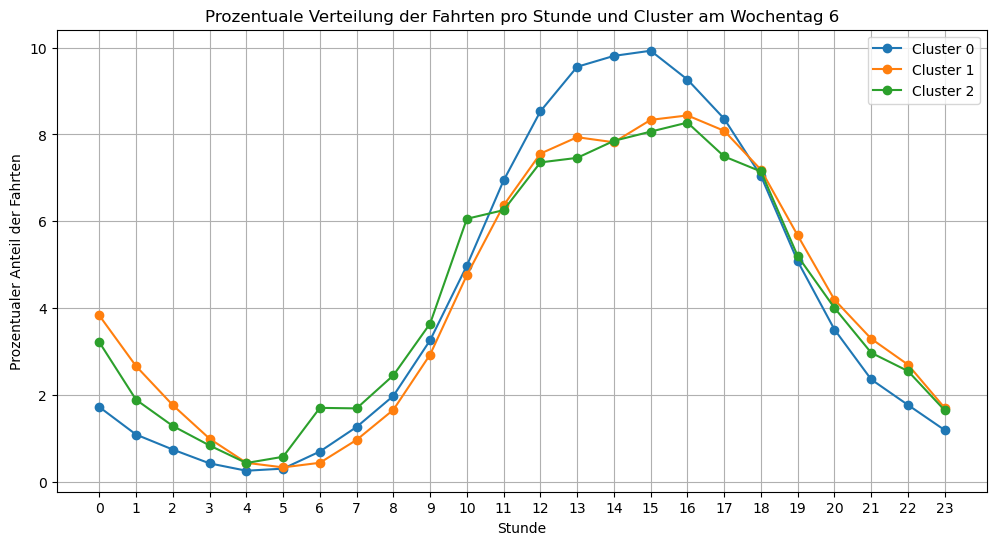

In [14]:
df['ended_at'] = pd.to_datetime(df['ended_at'])
df['hour'] = df['ended_at'].dt.hour
df['weekday'] = df['ended_at'].dt.weekday

# 1. Gesamtzahl der Fahrten pro Cluster und Wochentag
total_rides_cluster_weekday = df.groupby(['cluster', 'weekday']).ride_id.count().reset_index(name='total_cluster_weekday_rides')

# 2. Stündliche Fahrten pro Cluster und Wochentag
hourly_rides_cluster_weekday = df.groupby(['cluster', 'weekday', 'hour']).ride_id.count().reset_index(name='hourly_cluster_rides')

# 3. Zusammenführen der Gesamt- und stündlichen Fahrten
merged_rides = pd.merge(hourly_rides_cluster_weekday, total_rides_cluster_weekday, on=['cluster', 'weekday'])

# 4. Prozentualen Anteil berechnen
merged_rides['percentage'] = (merged_rides['hourly_cluster_rides'] / merged_rides['total_cluster_weekday_rides']) * 100

# Umwandlung in ein Pivot-Table für das einfache Plotten
pivot_data = merged_rides.pivot_table(index=['hour', 'weekday'], columns='cluster', values='percentage', fill_value=0)

# Plotten
for weekday in range(7):  # Für jeden Wochentag
    plt.figure(figsize=(12, 6))
    for cluster in sorted(df['cluster'].unique()):
        if cluster in pivot_data.columns:  # Überprüfung, ob der Cluster vorhanden ist
            data_to_plot = pivot_data.xs(weekday, level='weekday')[cluster]
            plt.plot(data_to_plot.index, data_to_plot, label=f'Cluster {cluster}', marker='o')
        
    plt.title(f'Prozentuale Verteilung der Fahrten pro Stunde und Cluster am Wochentag {weekday}')
    plt.xlabel('Stunde')
    plt.ylabel('Prozentualer Anteil der Fahrten')
    plt.legend()
    plt.grid(True)
    plt.xticks(np.arange(24))  # Stellen Sie sicher, dass alle Stunden markiert sind
    plt.show()

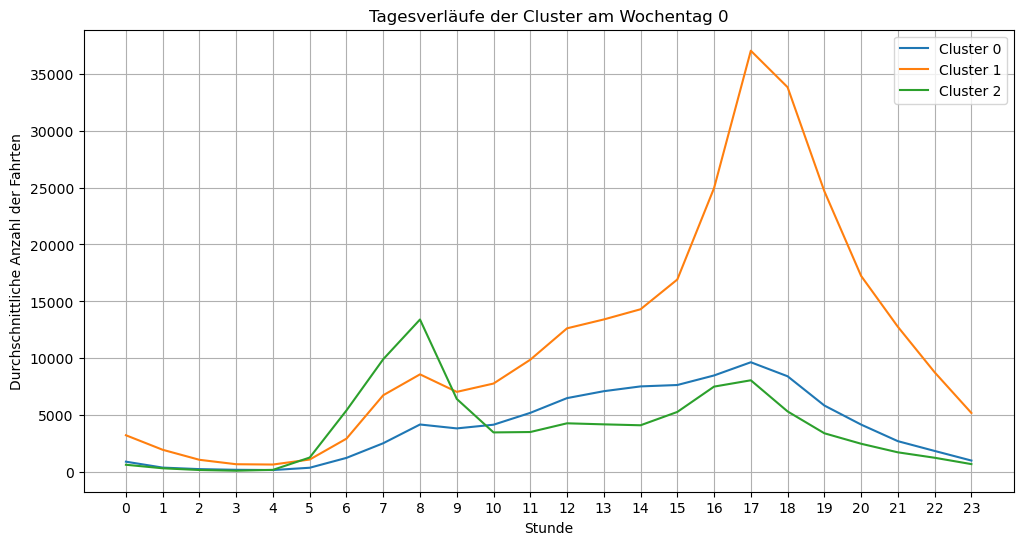

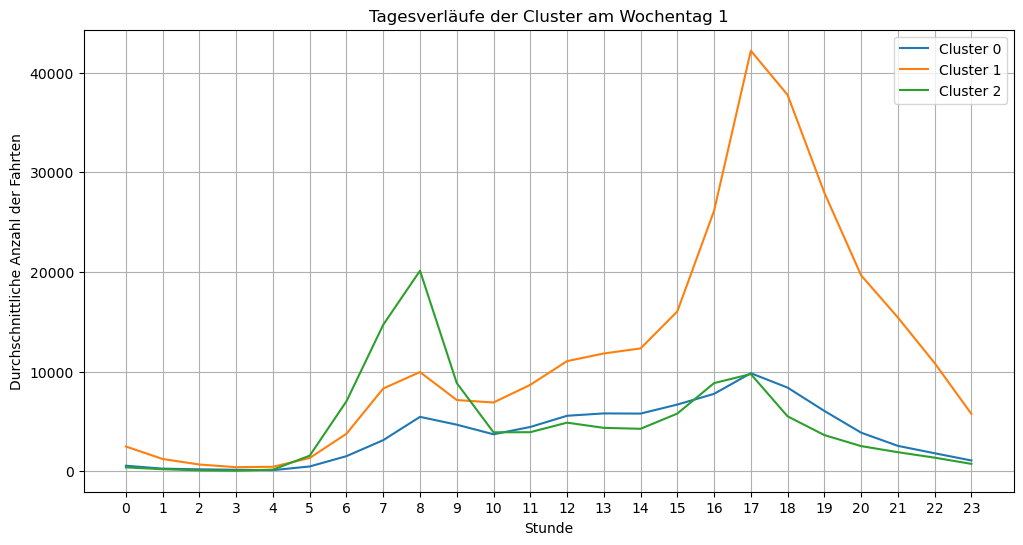

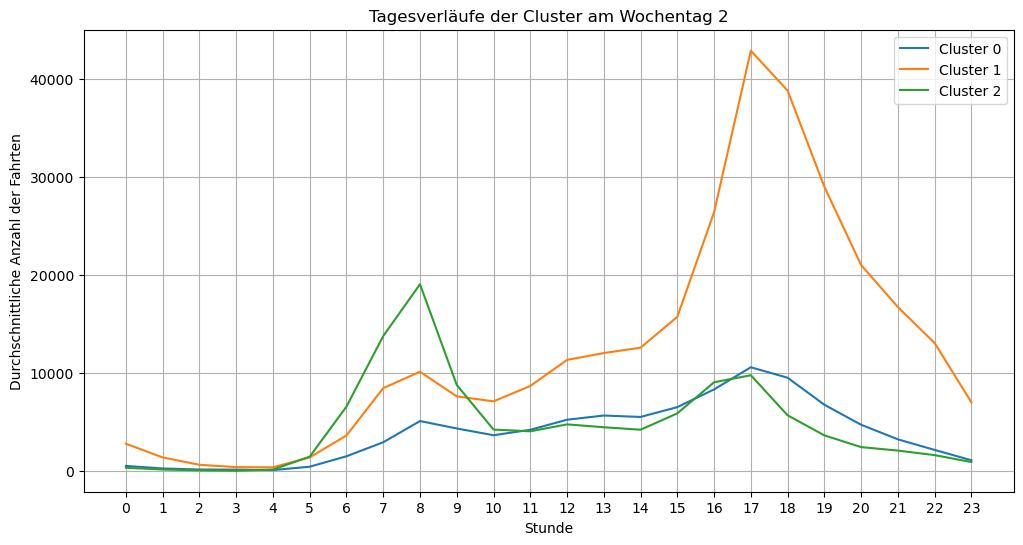

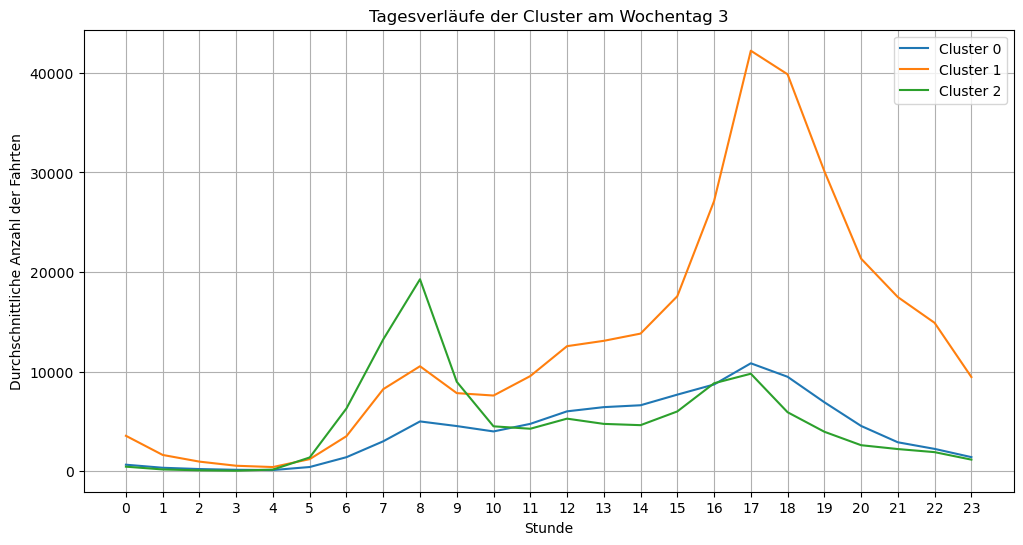

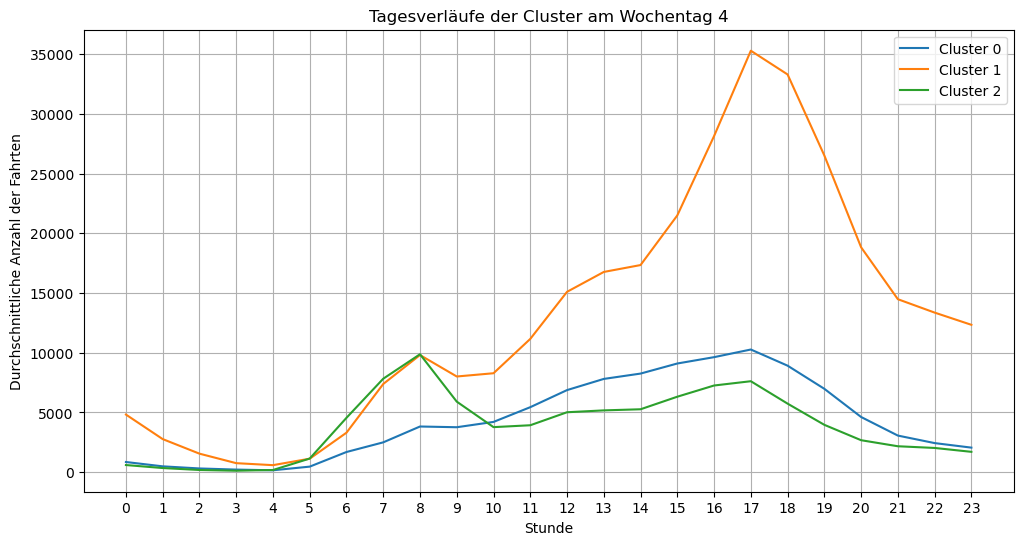

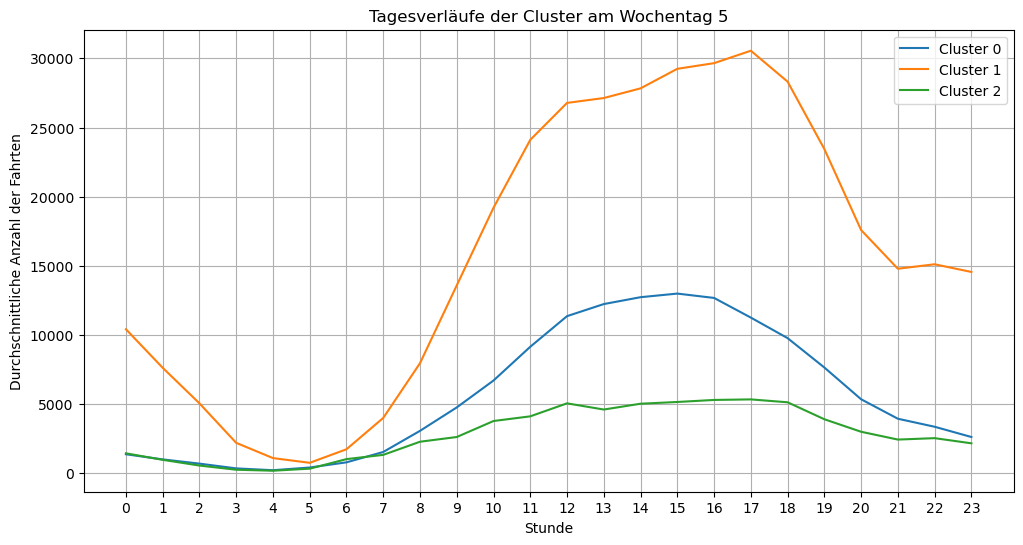

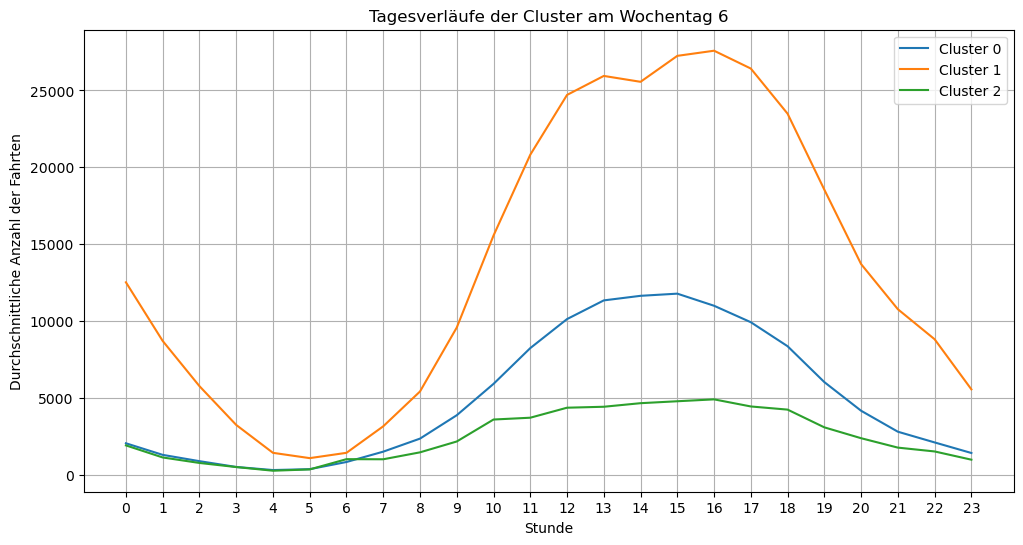

In [15]:
# Umwandlung der 'started_at' in datetime und Erstellung der 'hour' und 'weekday' Spalten, falls noch nicht vorhanden
df['ended_at'] = pd.to_datetime(df['ended_at'])
df['hour'] = df['ended_at'].dt.hour
df['weekday'] = df['ended_at'].dt.weekday

# Aggregieren der Daten: Anzahl der Fahrten pro Stunde und Wochentag für jeden Cluster
agg_data = df.groupby(['cluster', 'weekday', 'hour']).ride_id.count().reset_index(name='ride_count')

# Umwandlung in ein Pivot-Table für das einfache Plotten
pivot_data = agg_data.pivot_table(index=['hour', 'weekday'], columns='cluster', values='ride_count', fill_value=0)

# Plotten
for weekday in range(7):  # Für jeden Wochentag
    plt.figure(figsize=(12, 6))
    for cluster in sorted(df['cluster'].unique()):
        data_to_plot = pivot_data.xs(weekday, level='weekday')[cluster]
        plt.plot(data_to_plot.index, data_to_plot, label=f'Cluster {cluster}')
        
    plt.title(f'Tagesverläufe der Cluster am Wochentag {weekday}')
    plt.xlabel('Stunde')
    plt.ylabel('Durchschnittliche Anzahl der Fahrten')
    plt.legend()
    plt.grid(True)
    plt.xticks(np.arange(24))  # Stellen Sie sicher, dass alle Stunden markiert sind
    plt.show()

In [16]:
# Schritt 1: Aggregation der Fahrten pro Stunde und Wochentag für jede Station
station_hour_weekday_counts = df.groupby(['end_station_id', 'weekday', 'hour'])['ride_id'].count().reset_index(name='ride_counts')

# Schritt 2: Umwandlung in ein Pivot-Table, um Feature-Vektoren für jede Station zu erstellen
pivot_df = station_hour_weekday_counts.pivot_table(index='end_station_id', columns=['weekday', 'hour'], values='ride_counts', fill_value=0)

# Angenommen, du hast bereits ein DataFrame 'clusters' mit den Spalten 'start_station_id' und 'cluster', das die Cluster-Zuweisung für jede Station angibt
pivot_df = pivot_df.merge(unique_stations[['end_station_id', 'cluster']], on='end_station_id')

# Schritt 3: Berechnung des durchschnittlichen Feature-Vektors für jeden Cluster
cluster_feature_vectors = pivot_df.groupby('cluster').mean()

/var/folders/y8/j3l3spt14jd5q6r19v3l8_800000gn/T/ipykernel_2158/3842673609.py:8: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  pivot_df = pivot_df.merge(unique_stations[['end_station_id', 'cluster']], on='end_station_id')
/var/folders/y8/j3l3spt14jd5q6r19v3l8_800000gn/T/ipykernel_2158/3842673609.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cluster_feature_vectors = pivot_df.groupby('cluster').mean()


In [17]:


# Angenommen, 'cluster_vectors' ist ein Array von Feature-Vektoren für die Cluster
# Beispiel: cluster_vectors = [vector1, vector2, vector3, ...]

# Berechnung der Cosine-Similarity-Matrix
similarity_matrix = cosine_similarity(cluster_feature_vectors)

# Anzeigen der Cosine-Similarity-Matrix
print(similarity_matrix)

[[1.         0.95579583 0.7781498 ]
 [0.95579583 1.         0.73430017]
 [0.7781498  0.73430017 1.        ]]


In [18]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Stellen Sie sicher, dass 'started_at' im datetime-Format ist
df['ended_at'] = pd.to_datetime(df['ended_at'])

# Füge eine Spalte für den Wochentag hinzu (Montag=0, Dienstag=1)
df['weekday'] = df['ended_at'].dt.weekday

# Füge eine Spalte für die Stunde des Tages hinzu
df['hour'] = df['ended_at'].dt.hour

# Filtere die Daten für Montag und Dienstag
df_mon_tue = df[df['weekday'].isin([0, 1, 2, 3 ,4 ])]

# Aggregiere die Daten, um die Anzahl der Fahrten pro Stunde zu zählen
hourly_rides = df_mon_tue.groupby(['weekday', 'hour'])['ride_id'].count().reset_index(name='ride_count')

# Sortiere die Daten nach 'weekday' und 'hour' für die Zeitreihenanalyse
hourly_rides_sorted = hourly_rides.sort_values(by=['weekday', 'hour'])

# Die Zeitreihe für den ADF-Test vorbereiten (Nur die Anzahl der Fahrten)
time_series = hourly_rides_sorted['ride_count']

result = adfuller(time_series)

print('ADF Statistik: %f' % result[0])
print('p-Wert: %f' % result[1])
print('Kritische Werte:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[1] > 0.05:
    print("Die Zeitreihe ist nicht-stationär.")
else:
    print("Die Zeitreihe ist stationär.")

ADF Statistik: -5.450202
p-Wert: 0.000003
Kritische Werte:
	1%: -3.494
	5%: -2.889
	10%: -2.582
Die Zeitreihe ist stationär.


In [19]:
from statsmodels.tsa.stattools import kpss

# KPSS-Test
statistic, p_value, n_lags, critical_values = kpss(time_series, 'c')

print(f'KPSS Statistik: {statistic}')
print(f'p-Wert: {p_value}')
print('Kritische Werte:')
for key, value in critical_values.items():
    print(f'\t{key}: {value}')

if p_value < 0.05:
    print("Die Nullhypothese wird abgelehnt. Die Zeitreihe ist nicht stationär.")
else:
    print("Die Nullhypothese kann nicht abgelehnt werden. Die Zeitreihe ist stationär.")


KPSS Statistik: 0.10102384799448898
p-Wert: 0.1
Kritische Werte:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
Die Nullhypothese kann nicht abgelehnt werden. Die Zeitreihe ist stationär.


/Users/mariu/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
